# Encabezado

### Librerias

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
from urllib.parse import urlparse
import re
import math
import idna
import nltk
from nltk.corpus import words

### Parte 1 – Ingeniería de características

### Exploración de datos

1. Cargue el dataset en un dataframe de pandas, muestre un ejemplo de cinco observaciones.

In [45]:
import pandas as pd

csv_path = './data/dataset_pishing.csv'
df = pd.read_csv(csv_path)

ejemplo_observaciones = df.head(5)
display(ejemplo_observaciones)


,url,status
0,http://www.crestonwood.com/router.php,legitimate
1,http://shadetreetechnology.com/V4/validation/a...,phishing
2,https://support-appleld.com.secureupdate.duila...,phishing
3,http://rgipt.ac.in,legitimate
4,http://www.iracing.com/tracks/gateway-motorspo...,legitimate


2. Muestre la cantidad de observaciones etiquetadas en la columna status como “legit” y como
“pishing”. ¿Está balanceado el dataset?

Cantidad de observaciones etiquetadas como 'legit': 5715
Cantidad de observaciones etiquetadas como 'pishing': 5715


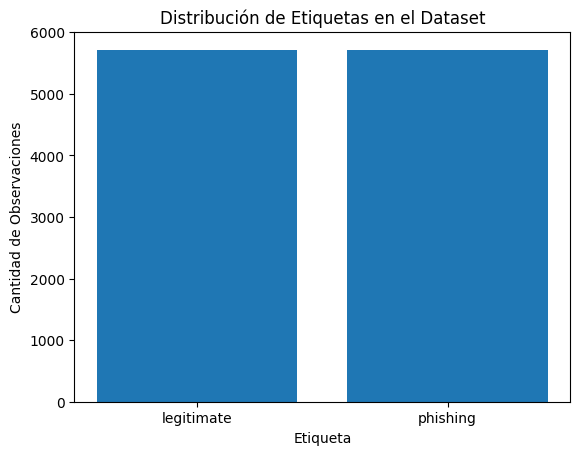

In [46]:
conteo_etiquetas = df['status'].value_counts()

print("Cantidad de observaciones etiquetadas como 'legit':", conteo_etiquetas['legitimate'])
print("Cantidad de observaciones etiquetadas como 'pishing':", conteo_etiquetas['phishing'])


plt.bar(conteo_etiquetas.index, conteo_etiquetas)
plt.xlabel('Etiqueta')
plt.ylabel('Cantidad de Observaciones')
plt.title('Distribución de Etiquetas en el Dataset')

plt.show()

El dataset está perfectamente balanceado, dado que hay la misma cantidad de links legítimos y de phising.

### Derivación de características
En base a los artículos propuestos de clasificación de phishing, responda las siguientes preguntas:
1. ¿Qué ventajas tiene el análisis de una URL contra el análisis de otros datos, cómo el tiempo
de vida del dominio, o las características de la página Web?
2. ¿Qué características de una URL son más prometedoras para la detección de phishing?

En base a la respuesta anterior escriba al menos quince funciones basadas en los artículos, para
derivar características que un modelo pueda utilizar y añada dichas características al dataset original.

## Derivación de características.

1. ¿Qué ventajas tiene el análisis de una URL contra el análisis de otros datos, como el tiempo de vida del dominio, o las características de la página Web?

- La ventaja que tiene el análisis de una URL es que se analiza su string puro y con ello se puede saber si tiene caracteres especiales que podrían no existir en un link legítimo en caso de ser fraudulentos.

2. ¿Qué características de una URL son más prometedoras para la detección de phishing?

- Las características más prometedoras de un link son los números, @ y/o cualquier otro caracter especial. Otras características especiales pueden ser también la cantidad de veces que aparecen los números o caracteres especiales.


## Escribiendo al menos quince funciones basadas en los artículos.

Analizando la longitud del link.

In [47]:
def calculate_url_lengths(df):
    # Añade nuevas columnas al DataFrame para almacenar las longitudes
    df['full_url_length'] = df['url'].apply(len)
    df['hostname_length'] = df['url'].apply(lambda x: len(urlparse(x).hostname))

    return df


df = calculate_url_lengths(df)

print(df)

# # Sobreescribiendo el archivo CSV con las nuevas columnas.
# df.to_csv(csv_path, index=False)

# Escribiendo un nuevo archivo CSV con las nuevas columnas.
new_csv_path = './data/new_dataset.csv'
df.to_csv(new_csv_path, index=False)

                                                     url      status   
0                  http://www.crestonwood.com/router.php  legitimate  \
1      http://shadetreetechnology.com/V4/validation/a...    phishing   
2      https://support-appleld.com.secureupdate.duila...    phishing   
3                                     http://rgipt.ac.in  legitimate   
4      http://www.iracing.com/tracks/gateway-motorspo...  legitimate   
...                                                  ...         ...   
11425      http://www.fontspace.com/category/blackletter  legitimate   
11426  http://www.budgetbots.com/server.php/Server%20...    phishing   
11427  https://www.facebook.com/Interactive-Televisio...  legitimate   
11428             http://www.mypublicdomainpictures.com/  legitimate   
11429  http://174.139.46.123/ap/signin?openid.pape.ma...    phishing   

       full_url_length  hostname_length  
0                   37               19  
1                   77               23  
2        

Caracteres especiales

In [48]:
def count_special_characters(df):
    special_characters = ['.', '-', '@', '?', '&', '|', '=', '_', ' ̃', '%', '/', '*', ':', ',', ';', '$', '%20']

    for char in special_characters:
        col_name = f'f{special_characters.index(char) + 4}'  # Agregando 'f' para evitar errores en el nombre de la columna.
        df[col_name] = df['url'].apply(lambda x: x.count(char))

    return df


df = count_special_characters(df)

print(df)

#  Sobreescribiendo el archivo CSV con las nuevas columnas.
new_csv_path = './data/new_dataset.csv'
df.to_csv(new_csv_path, index=False)

                                                     url      status   
0                  http://www.crestonwood.com/router.php  legitimate  \
1      http://shadetreetechnology.com/V4/validation/a...    phishing   
2      https://support-appleld.com.secureupdate.duila...    phishing   
3                                     http://rgipt.ac.in  legitimate   
4      http://www.iracing.com/tracks/gateway-motorspo...  legitimate   
...                                                  ...         ...   
11425      http://www.fontspace.com/category/blackletter  legitimate   
11426  http://www.budgetbots.com/server.php/Server%20...    phishing   
11427  https://www.facebook.com/Interactive-Televisio...  legitimate   
11428             http://www.mypublicdomainpictures.com/  legitimate   
11429  http://174.139.46.123/ap/signin?openid.pape.ma...    phishing   

       full_url_length  hostname_length  f4  f5  f6  f7  f8  f9  ...  f11   
0                   37               19   3   0   0   0   

Calculando la proporción de dígitos en las URL's completas y en los hostnames.

In [49]:
def calculate_digit_ratio(df):
    df['full_url_digit_ratio'] = df['url'].apply(lambda x: sum(c.isdigit() for c in x) / len(x) if len(x) > 0 else 0)
    df['hostname_digit_ratio'] = df['url'].apply(lambda x: sum(c.isdigit() for c in urlparse(x).hostname) / len(urlparse(x).hostname) if urlparse(x).hostname else 0)

    return df

df = calculate_digit_ratio(df)

# Sobreescribiendo el archivo CSV con las nuevas columnas.
new_csv_path = './data/new_dataset.csv'
df.to_csv(new_csv_path, index=False)

Detectando subdominios anormales 

In [50]:
def es_phishing(url):
    # Extrayendo el subdominio de la url
    subdominio = urlparse(url).hostname.split('.')[0]
    
    if re.match(r'w[w]?[0-9]*', subdominio):
        return True
    else:
        return False

df['abnormal_domain'] = df['url'].apply(es_phishing)

# Escribiendo un nuevo archivo CSV con las nuevas columnas.
new_csv_path = './data/new_dataset.csv'
df.to_csv(new_csv_path, index=False)

Dominios random

In [51]:
def calcular_entropia(s):
    # Contando la frecuencia de cada carácter en la cadena
    frecuencia = [float(s.count(c)) / len(s) for c in dict.fromkeys(list(s))]
    
    # Calculando la entropia
    entropia = -sum([p * math.log(p) / math.log(2.0) for p in frecuencia])
    
    return entropia

def random_domain(url):
    dominio = urlparse(url).hostname
    
    entropia = calcular_entropia(dominio)
    
    # Si la entropia es mayor que un cierto umbral, consideramos que el dominio es aleatorio
    if entropia > 4:
        return True
    else:
        return False

df['random_domain'] = df['url'].apply(random_domain)

new_csv_path = './data/new_dataset.csv'
df.to_csv(new_csv_path, index=False)

Prefijos y sufijos

In [52]:
def prefix_suffix(url):
    # Extrayendo el dominio de la url
    dominio = urlparse(url).hostname
    
    # Comprobando si el dominio contiene "-"
    if '-' in dominio:
        return True
    else:
        return False

# Buscando los prefijos y sufijos en los dominios
df['prefix_suffix'] = df['url'].apply(prefix_suffix)


new_csv_path = './data/new_dataset.csv'
df.to_csv(new_csv_path, index=False)

Términos comunes

In [53]:
def common_terms(url):
    # Definiendo los términos comunes que quieres buscar
    terminos_comunes = ['www', '.com', 'http', '//']
    
    # Comprobando si todos los términos comunes están presentes en la url
    return all(termino in url for termino in terminos_comunes)

df['common_terms'] = df['url'].apply(common_terms)

new_csv_path = './data/new_dataset.csv'
df.to_csv(new_csv_path, index=False)

Puny code

In [54]:
def punycode(url):
    # Extrayendo el dominio de la url
    dominio = urlparse(url).hostname
    
    # Intentando convertir el dominio a ASCII usando la biblioteca idna
    try:
        dominio_ascii = idna.encode(dominio).decode('utf-8')
    except idna.IDNAError:
        # Si se produce un error,es porque el url ya esté en ASCII
        dominio_ascii = dominio
    
    # Comprobando si el dominio contiene "xn--", que es un indicador de Punycode
    if 'xn--' in dominio_ascii:
        return True
    else:
        return False

df['punycode'] = df['url'].apply(punycode)

new_csv_path = './data/new_dataset.csv'
df.to_csv(new_csv_path, index=False)

Contador de palabras

In [55]:
def word_count(url):
    palabras = re.split(r'\W+', url)
    return len(palabras)

# Aplicando la función a cada url en el dataset
df['word_count'] = df['url'].apply(word_count)

new_csv_path = './data/new_dataset.csv'
df.to_csv(new_csv_path, index=False)

                                                     url      status   
0                  http://www.crestonwood.com/router.php  legitimate  \
1      http://shadetreetechnology.com/V4/validation/a...    phishing   
2      https://support-appleld.com.secureupdate.duila...    phishing   
3                                     http://rgipt.ac.in  legitimate   
4      http://www.iracing.com/tracks/gateway-motorspo...  legitimate   
...                                                  ...         ...   
11425      http://www.fontspace.com/category/blackletter  legitimate   
11426  http://www.budgetbots.com/server.php/Server%20...    phishing   
11427  https://www.facebook.com/Interactive-Televisio...  legitimate   
11428             http://www.mypublicdomainpictures.com/  legitimate   
11429  http://174.139.46.123/ap/signin?openid.pape.ma...    phishing   

       full_url_length  hostname_length  f4  f5  f6  f7  f8  f9  ...  f19   
0                   37               19   3   0   0   0   

Revisando si tiene caracteres especiales

In [56]:
def repeatead_characters(url):
    if re.search(r'(.)\1', url):
        return True
    else:
        return False

df['repeatead_characters'] = df['url'].apply(repeatead_characters)

new_csv_path = './data/new_dataset.csv'
df.to_csv(new_csv_path, index=False)